# Tutorial 9: Spatial alignment

This tutorial demonstrates the visualization of alignment results generated by stGCL. The slices are colored according to whether each spatial region is correctly aligned (“Region Match”) or misaligned (“Region Mismatch”), where spots are shown in green if correctly matched to the expert annotation and in red if mismatched. Here, we use the mouse hypothalamic preoptic area dataset generated by MERFISH. The processed data can be downloaded from https://zenodo.org/records/8137326/files/Mouse_hypothalamus.rar?download=1.

## Preparation

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
from datetime import datetime
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,vertical_list_alignment
import anndata as ad

In [3]:
bregma = [-0.04, -0.09,-0.14,-0.19,-0.24]
ARIlist = []
rfARIlist = []
list_z=[40,90,140,190,240]
list_adata=[]
dataset_batch=[]

for section_id in bregma:
    # section_id=-0.14
    k = 8
    rad_cutoff = 130
    H = [100, 30]
    epoch =1200
    top_genes = 3000
    load = False
    use_image = False
    alph = 0.04
    radius=60


    counts_file = os.path.join('/home/dell/GB/stGCL/stGCL/Data/Mouse_hippocampus_MERFISH/{} _cnts.csv'.format(section_id))
    coor_file = os.path.join('/home/dell/GB/stGCL/stGCL/Data/Mouse_hippocampus_MERFISH/{} _info.csv'.format(section_id))
    counts = pd.read_csv(counts_file,header=0, index_col=0, sep=',')
    coor_df = pd.read_csv(coor_file,header=0, index_col=0, sep=',')
    print(section_id,counts.shape, coor_df.shape)
    #
    counts=counts.T
    counts.index  = coor_df.index

    coor_df.columns = ['x','y',"ct","ct2","ground_truth"]
    coor_df['z']=section_id

    adata_temp = sc.AnnData(counts)
    adata_temp.var_names_make_unique()
    adata_temp.obs = coor_df

    adata_temp.obs["x_pixel"] = coor_df["x"]
    adata_temp.obs["y_pixel"] = coor_df["y"]
    adata_temp.obs["z_pixel"] = coor_df["z"]

    adata_temp.obsm["spatial"] = coor_df.loc[adata_temp.obs_names, ["x", "y","z"]].to_numpy()

    list_adata.append(adata_temp)
    dataset_batch.append("merish"+str(section_id))

-0.04 (155, 5488) (5488, 5)
-0.09 (155, 5557) (5557, 5)
-0.14 (155, 5926) (5926, 5)
-0.19 (155, 5803) (5803, 5)
-0.24 (155, 5543) (5543, 5)


## Alignment

In [4]:
adata=vertical_list_alignment(list_adata,list_z=list_z,batch_categories=dataset_batch,rad_cutoff=rad_cutoff)

-2148.001710696611 3729.2713008903065


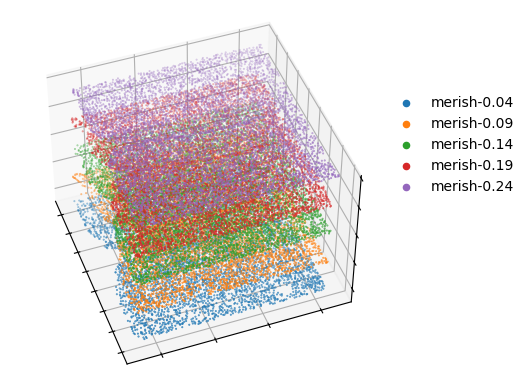

In [5]:
%matplotlib inline 
section_colors = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']
ax1 = plt.axes(projection='3d')
for section in dataset_batch:
    temp_Coor = adata.obs[adata.obs["dataset_batch"]==section]
    temp_xd = temp_Coor["x_pixel"]
    temp_yd = temp_Coor["y_pixel"]
    temp_zd = temp_Coor["z_pixel"]
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, s=0.2, marker="o", label=section)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
plt.legend(bbox_to_anchor=(1,0.8), markerscale=10, frameon=False)

ax1.elev = 45
ax1.azim = -20
plt.show()

## Alignment quality evaluation

Region acc：0.7377  (correct 4281/5803)


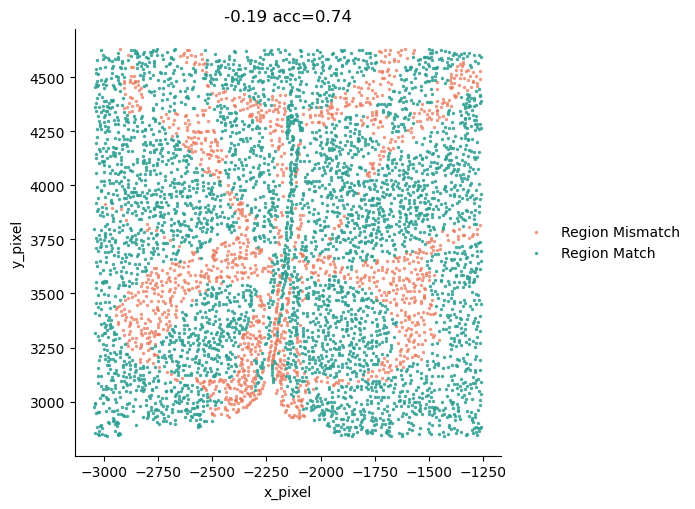

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


SRC_BATCH = "merish-0.19"     
DST_BATCH = "merish-0.14"     #


COORD_COLS = ["x_pixel", "y_pixel"]   


INVERT_Y      = False  
POINT_SIZE    = 6
COLOR_MATCH   = "#2a9d8f"   
COLOR_MISMATCH= "#e76f51"   
ALPHA_MATCH   = 0.85
ALPHA_MISMATCH= 0.70
LEGEND_OUT    = True     
DIST_THRESH   = None    
DROP_NAN_REG  = True   




A = adata[adata.obs["dataset_batch"] == SRC_BATCH].copy()
B = adata[adata.obs["dataset_batch"] == DST_BATCH].copy()


XA = A.obs[COORD_COLS].to_numpy()
XB = B.obs[COORD_COLS].to_numpy()
nn = NearestNeighbors(n_neighbors=1, algorithm="kd_tree")
nn.fit(XB)
dist, idx = nn.kneighbors(XA)
idx = idx[:, 0]
dist = dist[:, 0]

pairs = pd.DataFrame({
    "cell_src": A.obs_names.to_numpy(),
    "cell_dst": B.obs_names.to_numpy()[idx],
    "distance": dist
}).set_index("cell_src")


pairs["region_src"] = A.obs.loc[pairs.index, "ground_truth"].to_numpy()
pairs["region_dst"] = B.obs.loc[pairs["cell_dst"], "ground_truth"].to_numpy()
pairs["ct_src"]     = A.obs.loc[pairs.index, "ct"].to_numpy()
pairs["ct_dst"]     = B.obs.loc[pairs["cell_dst"], "ct"].to_numpy()


if DIST_THRESH is not None:
    pairs = pairs[pairs["distance"] <= float(DIST_THRESH)]


if DROP_NAN_REG:
    df_stat = pairs[["region_src", "region_dst"]].dropna()
else:
    df_stat = pairs[["region_src", "region_dst"]].copy()



region_match = (df_stat["region_src"] == df_stat["region_dst"])
region_acc   = float(region_match.mean())
print(f"Region acc：{region_acc:.4f}  (correct {int(region_match.sum())}/{len(region_match)})")


m = re.search(r'-(\d+(?:\.\d+)?)', SRC_BATCH)
suffix = m.group(0) if m else SRC_BATCH


match_series = (pairs["region_src"] == pairs["region_dst"]).reindex(A.obs_names)
if DROP_NAN_REG:
    valid = pairs[["region_src", "region_dst"]].notna().all(axis=1).reindex(A.obs_names, fill_value=False).to_numpy()
else:
    valid = np.ones(A.n_obs, dtype=bool)

is_match = match_series.fillna(False).to_numpy()

x = A.obs[COORD_COLS[0]].to_numpy()
y = A.obs[COORD_COLS[1]].to_numpy()

xm, ym = x[valid & is_match], y[valid & is_match]
xu, yu = x[valid & ~is_match], y[valid & ~is_match]

fig, ax = plt.subplots(figsize=(6.3, 5.2))
ax.scatter(xu, yu, s=POINT_SIZE, alpha=ALPHA_MISMATCH, label="Region Mismatch",
           color=COLOR_MISMATCH, linewidths=0, zorder=1)
ax.scatter(xm, ym, s=POINT_SIZE, alpha=ALPHA_MATCH, label="Region Match",
           color=COLOR_MATCH, linewidths=0, zorder=2)

ax.set_aspect("equal", adjustable="box")
if INVERT_Y:
    ax.invert_yaxis()


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


title_txt = f"{suffix} acc={region_acc:.2f}" if np.isfinite(region_acc) else f"{suffix} acc=NA"
ax.set_title(title_txt)
ax.set_xlabel(COORD_COLS[0])
ax.set_ylabel(COORD_COLS[1])


if LEGEND_OUT:
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    fig.tight_layout()
else:
    ax.legend(frameon=False)
    fig.tight_layout()


plt.show()